In [143]:
%matplotlib notebook
# for interactive charts use %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import seaborn as sns
import pandas as pd
import requests
import numpy as np
import datetime
import os.path
from scipy.optimize import curve_fit
plt.style.use('ggplot')

# Read in data

- Canadian data from [Isha Berry](https://github.com/ishaberry/Covid19Canada)

In [7]:
url = "https://docs.google.com/spreadsheets/d/1D6okqtBS3S2NRC7GFVHzaZ67DuTw7LX49-fqSLwJyeo/export?format=xlsx"
if datetime.date.today() != datetime.date.fromtimestamp(os.path.getmtime("canada.xlsx")):
    r = requests.get(url)
    with open("canada.xlsx", "wb") as output:
        output.write(r.content)

In [8]:
df = pd.read_excel("canada.xlsx", sheet_name = "Cases", skiprows = range(0, 3), index_col=0)

# Canada-wide cumulative cases

In [129]:
df_agg = df.groupby("date_report").apply(lambda x: x.count())
df_agg = df["date_report"].to_frame().groupby("date_report").apply(lambda x: x.count())
df_agg["date"] = df_agg.index
idx = pd.date_range(df_agg["date"].min(), df_agg["date"].max())
df_agg = df_agg.reindex(idx, fill_value=0)
df_agg["date"] = df_agg.index
df_agg["days"] = df_agg["date"].apply(lambda date: (date - start).days)
df_agg["cumulative"] = df_agg["date_report"].to_frame().expanding(1).sum()
df_agg.head()

,date_report,date,days,cumulative
2020-01-25,1,2020-01-25,18286,1.0
2020-01-26,0,2020-01-26,18287,1.0
2020-01-27,1,2020-01-27,18288,2.0
2020-01-28,1,2020-01-28,18289,3.0
2020-01-29,0,2020-01-29,18290,3.0


<IPython.core.display.Javascript object>


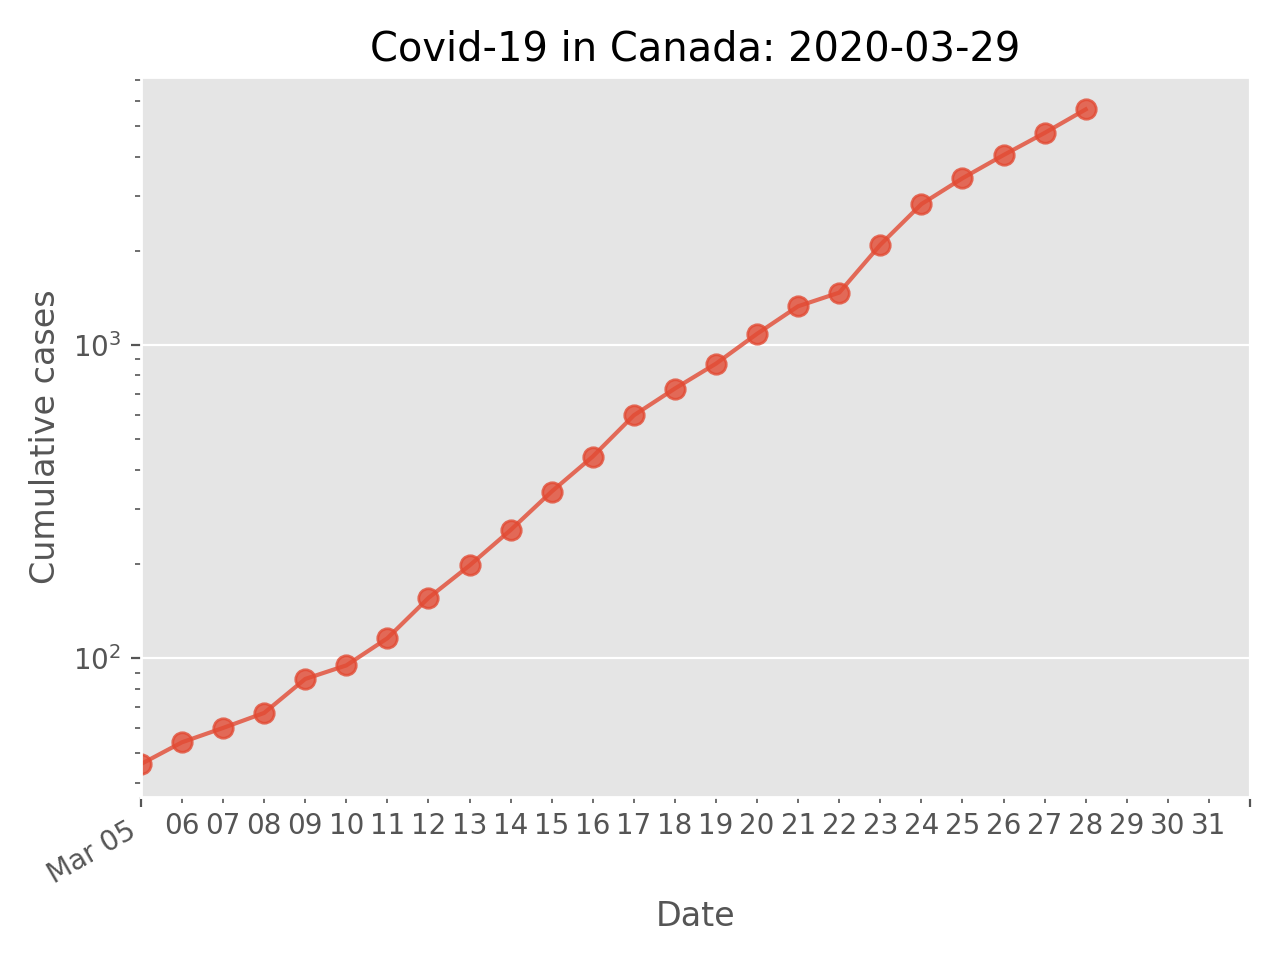

In [198]:
def plot_cumulative(data, scale="linear", start_days_after=35):
    # Use days as the x axis, which are days from 1970-01-01 or so (numbers like 18345)
    data = data.iloc[start_days_after:]
    data.plot(
        kind="line", y="cumulative", 
        marker='o',markersize=7, legend=None, alpha=0.8,
        title="Covid-19 in Canada: " + str(datetime.datetime.today().date())
    )
    plt.yscale(scale)
    plt.xlim(right=data["date"].max() + datetime.timedelta(days=4))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(base=1))
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(data.index)
    # Every 7th ticklable shows the month and day
    ticklabels[::7] = [item.strftime('%b %d') for item in data.index[::7]]
    plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate(ha="right")
    plt.gca().set_xlabel("Date")
    plt.gca().set_ylabel("Cumulative cases")

    # annotate recent values
    if scale=="linear":
        for x,y in zip(data["days"].to_list()[-5:], data["cumulative"].to_list()[-5:]):
            label = "{:.2f}".format(y)
            plt.annotate(label, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(-5,0), # distance from text to points (x,y)
                         ha='right') # horizontal
        plt.ylim(bottom=0, top=data["cumulative"].max() * 1.1)
    elif scale=="log":
        pass
    plt.tight_layout()
    plt.show()
    
plot_cumulative(data=df_agg[["date_report", "date", "days", "cumulative"]], scale="log", start_days_after=40)

[ 7.39897587e+01  1.83189130e+04  1.49708009e-01 -9.80563471e+02]


<IPython.core.display.Javascript object>


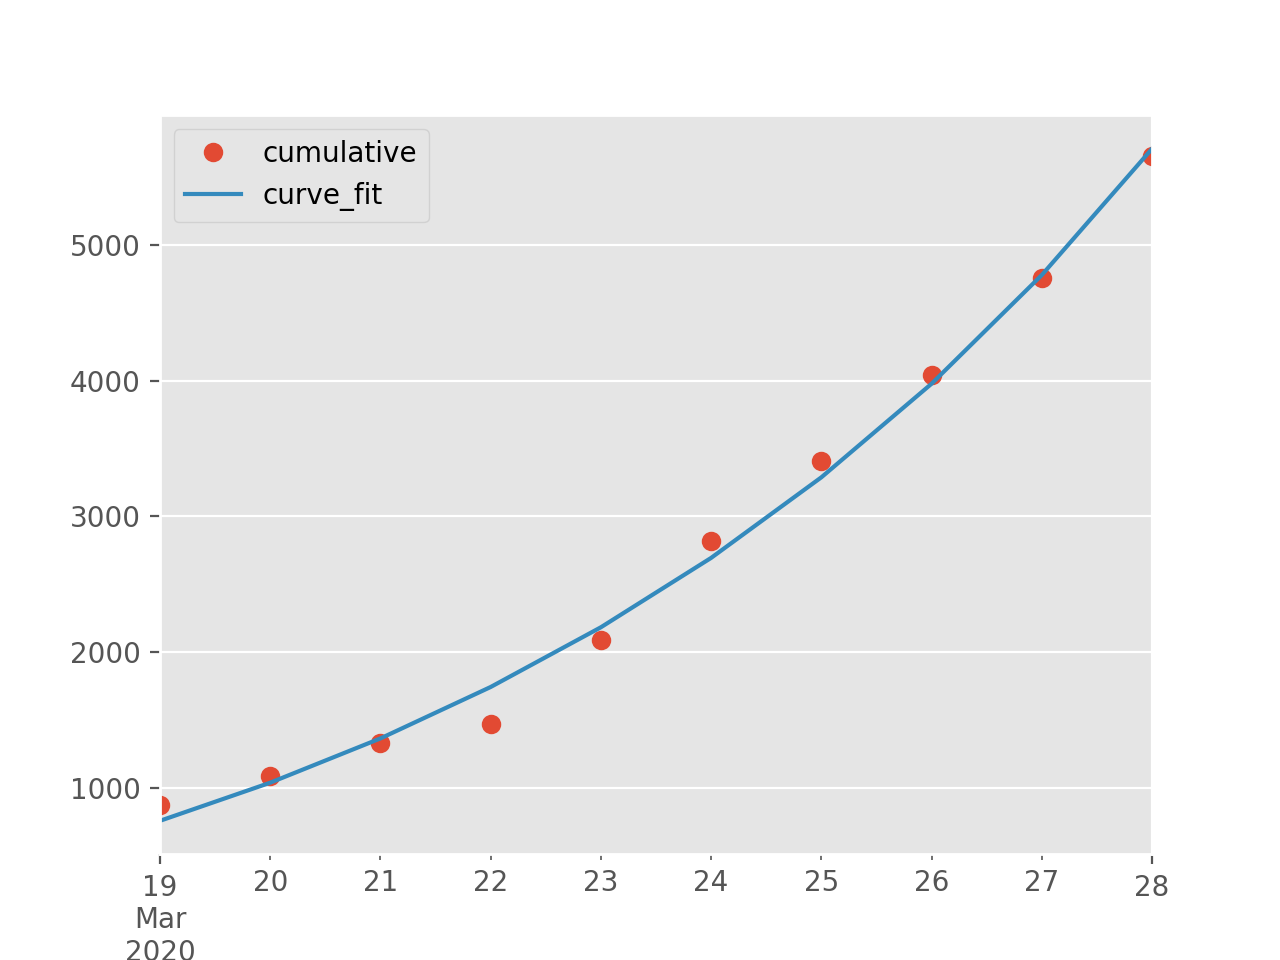

In [204]:
# From http://emilygraceripka.com/blog/14
# curve fit: define the fitting function
def fit_function(x, a, x0, k, b):
    return a * np.exp((x - x0) * k) + b
# feed it into scipy
popt, pcov = curve_fit(
    fit_function,
    df_agg["days"].to_list()[-10:], 
    df_agg["cumulative"].to_list()[-10:],
    p0 = (2, 18300, 3, -100),
    maxfev =100000)
print(popt)
df_agg["curve_fit"] = df_agg["days"].apply(lambda x: fit_function(x, popt[0], popt[1], popt[2], popt[3]))
df_agg.iloc[-10:].plot(kind="line", y=["cumulative", "curve_fit"], style=["o ", "-"])

<IPython.core.display.Javascript object>


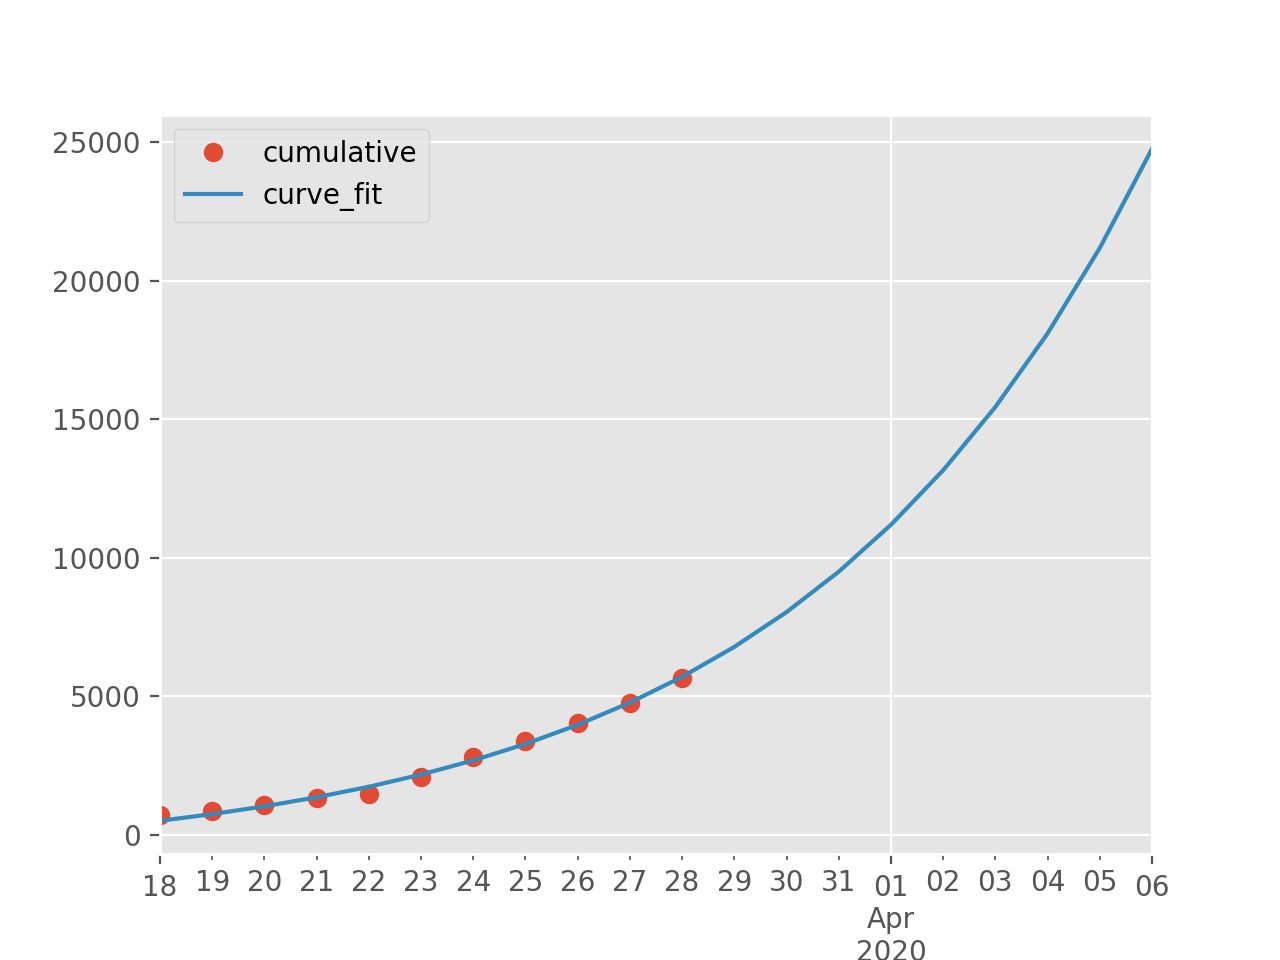

In [208]:
df_plot = df_agg[["days", "date", "cumulative", "curve_fit"]]
rowcount = len(df_plot)
today_row = df_plot.iloc[rowcount-1]
for days in range(1,10):
    this_days = today_row["days"] + days
    this_date = today_row["date"] + datetime.timedelta(days=days)
    df_plot.loc[this_date] = [this_days, this_date.date(), None, 
                  fit_function(this_days, *popt)]
df_plot.iloc[-20:].plot(y=["cumulative", "curve_fit"], style=["o ", "-"])
#plt.yscale("log")

# New cases per day

<IPython.core.display.Javascript object>


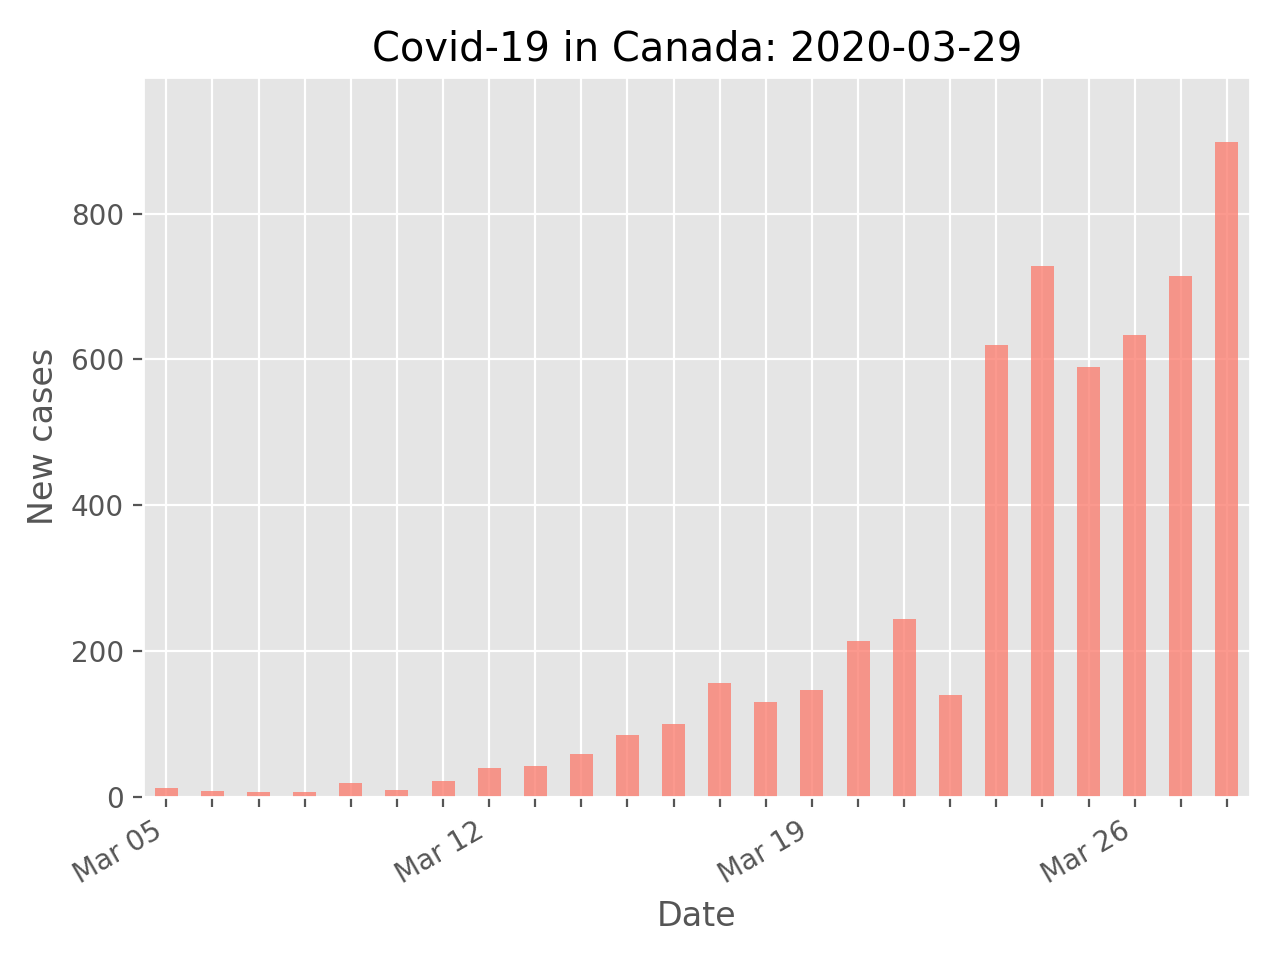

In [118]:
def plot_new_cases(data=df, start_days_after=35):
    data = data.iloc[start_days_after:]
    data.plot(
        kind="bar", y="date_report", legend=None, 
        color="salmon", alpha=0.8,
        title="Covid-19 in Canada: " + str(datetime.datetime.today().date())
    )
    plt.gca().set_xlabel("Date")
    plt.gca().set_ylabel("New cases")
    #plt.xlim(right=df_agg["date"].max() + datetime.timedelta(days=4))
    plt.ylim(bottom=0, top=data["date_report"].max() * 1.1)
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(data.index)
    # Every 7th ticklable shows the month and day
    ticklabels[::7] = [item.strftime('%b %d') for item in data.index[::7]]
    plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate(ha="right")
    plt.tight_layout()
    plt.show()
plot_new_cases(data=df_agg, start_days_after=40)

In [ ]:
plt.figure()
fig = sns.lineplot(data=df_agg, x="days", y="date_report")
plt.yscale("log")
plt.xlim(left=start_days_after, right=df_agg["days"].max() + 1)
plt.ylim(bottom=0, top=df_agg["date_report"].max() * 1.1)
new_labels = [(start + datetime.timedelta(days=item)).date() for item in plt.gca().get_xticks()]
plt.gca().set_xticklabels(new_labels, rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_agg = df["date_report"].to_frame().groupby("date_report").apply(lambda x: x.count())
df_agg.plot(marker='o', markersize=5, alpha=0.5, legend=None, rot=30, title="Daily new cases in Canada")
plt.xlabel("Date")
plt.xlim(left=datetime.date(2020, 3, 1))
#plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
# aggregate by age
df_agg = df["sex"].to_frame().groupby("sex").apply(lambda x: x.count())
df_agg.plot(kind="bar", alpha=0.5, legend=None, rot=45)
plt.show()